# Prédiction Qualité de l'aire et de la Pollution
# Outline
- [ 1 - Packages et global paraméters](#1)
- [ 2 - Qualité de l'air](#2)
  - [ 2.1 Etude liée à une commune](#2.1)
      - [ 2.1.1 Chargement et visualisation des données](#2.1.1)
      - [ 2.1.2 Modèle Sarima](#2.1.2)
      - [ 2.1.3 Neural Network](#2.1.3)
      - [ 2.1.4 LSTM](#2.1.4)
      - [ 2.1.5 Evaluations](#2.1.5)
  - [ 2.2 Etude plus générale (département/région/aasqua)](#2.2)
      - [ 2.2.1 Chargement et visualisation des données](#2.2.1)
      - [ 2.2.2 Modèle Sarima](#2.2.2)
      - [ 2.2.3 Neural Network](#2.2.3)
      - [ 2.2.4 Random Forest](#2.2.4)
      - [ 2.2.5 LSTM](#2.2.5)
      - [2.2.6 Evaluation](#2.2.6)
- [ 3 - Episode de pollution](#3)
  - [ 3.1 Problem Statement](#3.1)


<a name="1"></a>
## 1 - Packages et global paraméters

In [177]:
from utils import * #S'assurer que le fichier utils.py est dans le même repertoire
import numpy as np
import pandas as pd
from pymongo import MongoClient
from sklearn.model_selection import train_test_split
import seaborn as snc
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [178]:
csv_file = "./data/climat_france.aire_quality.csv"

<a name="2"></a>
## 2 - Air quality

In [179]:
id_data = 112

<a name="2.1"></a>
###   2.1 Etude sur une commune

In [180]:
# Choix d'un code zone au hasard
code_zone = "2017"

<a name="2.1.1"></a>
#### 2.1.1 Chargement et visualisation des données
- hypothèse : $x_{t+1} = f(x_t, x_{t-1}, \ldots)$, avec x : code_qual et t:date_ech
- Charger -> prétraiter -> Visualiser(décrire) --> corriger éventuellement variation saisonnières (Moyenne mobile/LR)


In [181]:
init_data = get_data_by_code_zone(csv_file ,code_zone)

In [182]:
print("dimension des données initiales", init_data.shape)

dimension des données initiales (1346, 18)


In [183]:
init_data.tail()

,_id,gml_id,aasqa,date_maj,partition_field,code_no2,code_o3,code_pm10,code_pm25,code_qual,code_so2,code_zone,coul_qual,date_dif,date_ech,lib_qual,lib_zone,source
22877,65dfe3d063ab081ada5286d8,976171877,32,2024-02-26 12:28:55.289000+00:00,322024w8,1,2,1,1,2,1,2017,#50CCAA,26/02/2024,25/02/2024,Moyen,ANGUILCOURT LE SART,Atmo HDF
22881,65dfe3d063ab081ada5286dc,980136519,32,2024-02-27 12:36:04.209000+00:00,322024w9,1,2,1,1,2,1,2017,#50CCAA,27/02/2024,26/02/2024,Moyen,ANGUILCOURT LE SART,Atmo HDF
22880,65dfe3d063ab081ada5286db,982440417,32,2024-02-28 12:01:05.622000+00:00,322024w9,1,2,1,1,2,1,2017,#50CCAA,28/02/2024,29/02/2024,Moyen,ANGUILCOURT LE SART,Atmo HDF
22878,65dfe3d063ab081ada5286d9,982440415,32,2024-02-28 12:01:05.622000+00:00,322024w9,1,2,1,2,2,1,2017,#50CCAA,28/02/2024,27/02/2024,Moyen,ANGUILCOURT LE SART,Atmo HDF
22879,65dfe3d063ab081ada5286da,982440416,32,2024-02-28 12:01:05.622000+00:00,322024w9,1,2,1,2,2,1,2017,#50CCAA,28/02/2024,28/02/2024,Moyen,ANGUILCOURT LE SART,Atmo HDF


In [184]:
# Mise à jour des données initiales.
data = update_zone_info(init_data, id_data, code_zone)

la date la plus recénte avant mise à jour : 2024-02-28 12:01:05.622000+00:00
Les données ont été mises à jour avec succès.
15 récentes observations on été ajouté


In [185]:
data.shape # taille initiale des données

(1361, 18)

In [186]:
print("dimension après maj", data.shape)

dimension après maj (1361, 18)


In [187]:
data.tail() # verifier qu'on a les dernières dans le champ date_maj

,_id,gml_id,aasqa,date_maj,partition_field,code_no2,code_o3,code_pm10,code_pm25,code_qual,code_so2,code_zone,coul_qual,date_dif,date_ech,lib_qual,lib_zone,source
1356,NaN,1026724442,32,2024-03-11 12:22:15.902000+00:00,322024w10,1,2,1,1,2,1,2017,#50CCAA,2024/03/11,2024-03-10,Moyen,ANGUILCOURT LE SART,Atmo HDF
1357,NaN,1029986817,32,2024-03-12 12:10:11.049000+00:00,322024w11,1,2,2,2,2,1,2017,#50CCAA,2024/03/12,2024-03-11,Moyen,ANGUILCOURT LE SART,Atmo HDF
1358,NaN,1033183072,32,2024-03-13 12:01:15.801000+00:00,322024w11,1,2,2,2,2,1,2017,#50CCAA,2024/03/13,2024-03-12,Moyen,ANGUILCOURT LE SART,Atmo HDF
1359,NaN,1038174918,32,2024-03-14 12:37:08.817000+00:00,322024w11,1,2,1,1,2,1,2017,#50CCAA,2024/03/14,2024-03-13,Moyen,ANGUILCOURT LE SART,Atmo HDF
1360,NaN,1040509062,32,2024-03-15 12:01:21.294000+00:00,322024w11,1,2,1,1,2,1,2017,#50CCAA,2024/03/15,2024-03-14,Moyen,ANGUILCOURT LE SART,Atmo HDF


In [188]:
# Suppression de la colonne id car crée par mongo
data = data.drop('_id', axis=1)
# Suppression des lignes avec des dates dupliquées
unique_date_ech = data.drop_duplicates(subset=['date_ech'])
unique_date_ech.nunique()

gml_id             1128
aasqa                 2
date_maj            832
partition_field     167
code_no2              3
code_o3               5
code_pm10             5
code_pm25             5
code_qual             4
code_so2              2
code_zone             2
coul_qual             4
date_dif            827
date_ech           1128
lib_qual              4
lib_zone              1
source                1
dtype: int64

In [189]:
len(unique_date_ech)

1128

In [190]:
nb_dup, unique_date_ech = remove_duplicates(unique_date_ech)
print(nb_dup)

0


In [191]:
def resample_by_day(df, window_size=1):
    df['date_ech'] = pd.to_datetime(df['date_ech'])  # Convertir en format datetime si ce n'est pas déjà fait
    last_date = df['date_ech'].iloc[-1]  # Dernière date du DataFrame
    freq = f'{window_size}D'  # Fréquence pour l'échantillonnage, par défaut 1 jour
    df_resampled = df.resample(freq, on='date_ech').mean()  # Échantillonner par jour avec la fréquence spécifiée et calculer la moyenne des valeurs
    df_resampled = df_resampled[df_resampled.index <= last_date]  # Limiter l'échantillonnage à la dernière date
    return df_resampled

In [208]:
# Échantillonner les dates par fenetre (jour/semaine/mois...), 
fenetre_echantillonage = 30 # on echantillone par mois, mais peut être changé, initialement on a par jour. 
df_resampled = resample_by_day(unique_date_ech[["date_ech", "code_qual"]], fenetre_echantillonage)

In [209]:
df_resampled.shape

(39, 1)

In [210]:
training_set, test_set = split_train_test_set(df_resampled, 0.2)

In [211]:
test_set.tail(5)

,code_qual
date_ech,
2023-10-19,2.034483
2023-11-18,1.928571
2023-12-18,2.000000
2024-01-17,2.150000
2024-02-16,2.000000


In [212]:
print("taille training set", len(training_set))
print("taille test set", len(test_set))

taille training set 31
taille test set 8


In [213]:
print(f"Les dimensions : training_set : {training_set.shape},"+
      f"test_set : {test_set.shape}")

Les dimensions : training_set : (31, 1),test_set : (8, 1)


In [214]:
# fonction pour interpoler les valeurs manquantes, on pourrais aussi avoir d'autre méthodes(foward_fill, backward_fill...)
def interpolate(y):
    y0 = y.copy()
    N = len(y0)
    pos = 0
    while pos < N:
        if np.isnan(y0[pos]):
            count = 0
            while np.isnan(y0[pos + count]):
                count += 1
            current = y0[pos - 1]
            future = y0[pos + count]
            slope = (future - current) / count
            y0[pos:pos + count] = current + np.arange(1, count + 1) * slope
            pos += count
        else:
            pos += 1
    return y0

df_interpoled = df_resampled.apply(interpolate)

Text(0.5, 0, 'date_ech')

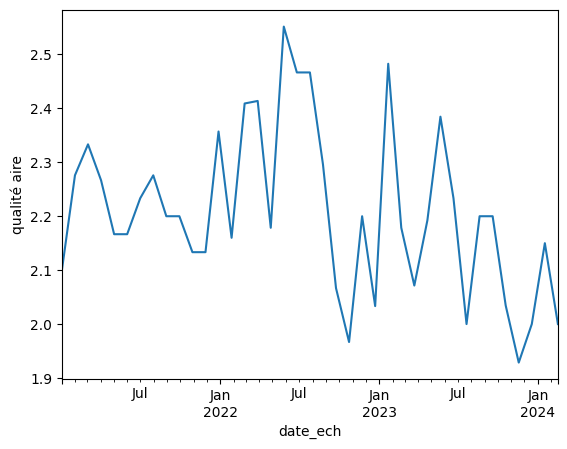

In [215]:
#df_resampled.set_index("date_ech", inplace=True)
df_interpoled.plot(legend=False)
ax = plt.gca()
ax.set_ylabel('qualité aire')
ax.set_xlabel('date_ech')

<a name="2.1.2"></a>
#### 2.1.2 Modèle Sarima
- Prévision basée sur modèle aléatoire tels que Sarima.
- hypothèse : on a une série temporelle qui présente une saisonnalité

*Contribution des prédicteurs*

<a name="2.1.3"></a>
#### 2.1.3 Neural Network

<a name="2.1.4"></a>
#### 2.1.4 LSTM

<a name="2.1.5"></a>
### 2.1.5 Evaluations

<a name="2.2"></a>
## 2.2 Etude plus générale (département/région/aasqua)

In [ ]:
def get_data_by_dep(csv_file, code_dept):
    # Charger le fichier CSV en un DataFrame
    df = pd.read_csv(csv_file, sep=';')
    
    # Filtrer les lignes pour les codes de zone commençant par le code du département spécifié
    data = df[df['code_zone'].astype(str).str.startswith(str(code_dept))]
    data = data.sort_values(by='date_ech')
    return data
df = get_data_by_dep(csv_file, 2)

In [ ]:
df.head()

In [ ]:
nb_dup, global_data = remove_duplicates(df)
print(nb_dup)

2.2 